In [ ]:
# Imports
import numpy as np
from numpy.lib.arraysetops import unique
from scipy.sparse import lil_matrix, csr_matrix, bmat
from scipy.sparse import linalg 
from scipy.sparse.linalg import spsolve

In [ ]:
# Import repository
! rm -fr * # delete all local files
! git clone https://gitlab.com/jan.zeman4/d32mhm2_en.git tmp 
! mv tmp/* . # copy to current directory
! rm -fr tmp/ # cleanup

Cloning into 'tmp'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 72 (delta 35), reused 51 (delta 23), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [ ]:
# Local functions
from show import show
from data import u_D_hmg 
from stima import stima3_hmg, rhs3_hmg_mult_rhs, hmg3_mult_rhs

In [ ]:
# Load all data
coordinates = np.loadtxt ( 'coordinates_hmg.dat', comments = '%' )
elements3 = np.loadtxt( 'elements3_hmg.dat', dtype = 'int', comments = '%' )
dirichlet = np.loadtxt( 'dirichlet_hmg.dat', dtype = 'int', comments = '%' )

# New data needed for homogenization
phases = np.loadtxt ( 'phases_hmg.dat', comments = '%' )
periodicity = np.loadtxt ( 'periodicity_hmg.dat', dtype = 'int', comments = '%' )

In [ ]:
# delete first columns from coordinates, elements3, elements4, and neumann arrays
coordinates = np.delete( coordinates, 0, 1 )
elements3 = np.delete( elements3, 0, 1 )
dirichlet = np.delete( dirichlet, 0, 1 )
phases = np.delete( phases, 0, 1 )
periodicity = np.delete( periodicity, 0, 1 )

In [ ]:
# setup matrices
FreeNodes = np.setdiff1d( range( coordinates.shape[0]), np.unique( dirichlet ) )
A = lil_matrix( np.zeros( (coordinates.shape[0], coordinates.shape[0]) ) ) 
b = np.zeros( (coordinates.shape[0], 2) )  
W = np.zeros( (coordinates.shape[0], 2) ) 

In [ ]:
# assembly of stiffness matrices and volume forces (triangular elements)
for j in range( elements3.shape[0] ):
   A[ np.ix_( elements3[j, 0:3], elements3[j, 0:3] ) ] += stima3_hmg( coordinates[ elements3[ j, 0:3], ], phases[ elements3[j, 3], ] )
   b[ elements3[j, 0:3], ] += rhs3_hmg_mult_rhs( coordinates[ elements3[ j, 0:3], ], phases[ elements3[j, 3], ] )

In [ ]:
# Prepare tying matrix T 
T = np.zeros( (periodicity.shape[0], coordinates.shape[0]) )

for j in range( periodicity.shape[0] ):
  T[j, periodicity[j, :]] = [1, -1]

The cell problem amount to solving the problem

\begin{align*}
 \underbrace{
   \begin{bmatrix}
   \bf{A}_\mathrm{FF} & \bf{T}_\mathrm{F}^\mathrm{T} \\
   \bf{T}_\mathrm{F} & \bf{0} 
   \end{bmatrix}
 }_{\bf{A}_\mathrm{hmg}}
 \underbrace{
   \begin{bmatrix}
   \bf{u}_\mathrm{F} \\
   \boldsymbol{\lambda}
   \end{bmatrix}
 }_{\bf{u}_\mathrm{hmg}}
 =
 \underbrace{
   \begin{bmatrix}
   \bf{b}_\mathrm{F} \\
   \bf{0}
   \end{bmatrix}
 }_{\bf{b}_\mathrm{hmg}}
\end{align*}

Therefore, we need to 
* assemble the extended system
* copy the respective parts of $\bf{u}_\mathrm{hmg}$ to solution

In [ ]:
# Setup the partitioned system

# Setup the partitioned system
A_hmg = bmat( [ [ A[ np.ix_( FreeNodes, FreeNodes) ], T[:, FreeNodes ].transpose() ], \
  [ T[:, FreeNodes ], None ] ] )
b_hmg = np.block( [ [ b[ FreeNodes, ] ], [ np.zeros( ( T.shape[0], 2 ) ) ] ] )

u_hmg = spsolve( A_hmg.tocsr(), b_hmg ) # Solve the partitioned system

W[ FreeNodes, ] = u_hmg[ 0:FreeNodes.shape[0], ]

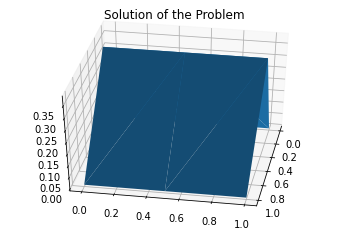

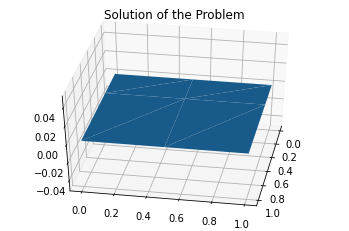

In [ ]:
# graphic representation
show(elements3[:, 0:3], np.array([]), coordinates, W[:, 0])
show(elements3[:, 0:3], np.array([]), coordinates, W[:, 1])

In [ ]:
# Perform homogenization
L_eff = np.zeros( (2, 2) ) # Effective conductivity matrix
Y = 0. # RVE area

for j in range( elements3.shape[0] ):
   L_effj, Aj = hmg3_mult_rhs( coordinates[ elements3[ j, 0:3], ], phases[ elements3[j, 3], ], \
                          W[ elements3[ j, 0:3], ] )
   Y += Aj
   L_eff += L_effj

L_eff /= Y # Normalize with respect to RVE area

print(L_eff)

In [19]:
# Check homogenized conductivity matrix [from Part I]
c = 0.3 # From input

L_eff_a = np.zeros( (2, 2) ) # Effective conductivity matrix

L_eff_a[0, 0] = 1./( c / phases[0, 0] + (1 - c) / phases[1, 0] ) # Reuss
L_eff_a[1, 1] = c*phases[0, 2] + (1-c)*phases[1, 2] # Voigt

print( L_eff_a )
print( np.linalg.norm( L_eff - L_eff_a ) ) # To be checked

[[ 4.54545455  0.        ]
 [ 0.         14.6       ]]
3.66205343881779e-15
